# Table of Contents
 <p>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import numpy.random as rnd
from scipy.special import expit

import seaborn as sns
import matplotlib.pyplot as plt

from util import trunc_norm

In [6]:
n  = 10   # number of clients in the group
n_ = 10   # number of clients in the other group
N  = 6    # 10**N number of samples

e1 = 0.5
e2 = 0.5

a = expit(e1)
b = expit(e2)

a_ = 1 - a
b_ = 1 - b

In [7]:
def gen_data(samples, seed=0):
    np.random.seed(seed)
    
    A = np.ones((samples, n), dtype=int)
    B = np.zeros((samples, n_), dtype=int)
    g = np.concatenate((A, B), axis=1)
    
    vA = trunc_norm(loc=0., scale=0.33, size=n)
    vB = np.zeros(n_, dtype=float)
    
    v = np.concatenate((vA, vB))
    v = np.tile(v, (samples, 1))

    # DP protection
    new_g, new_v = g.copy(), v.copy()
    new_v = rnd.binomial(1, (1 + new_v) / 2)
    
    rr_group = rnd.binomial(1, 1 - a, size=g.shape).astype(bool)
    new_g[rr_group] = 1 - new_g[rr_group]
    
    rr_value = rnd.binomial(1, 1 - b, size=v.shape).astype(bool)
    new_v[rr_value] = 1 - new_v[rr_value]
    new_v = 2 * new_v - 1
    
    return np.ma.array(v, mask=1 - g), np.ma.array(new_v, mask=1 - new_g)

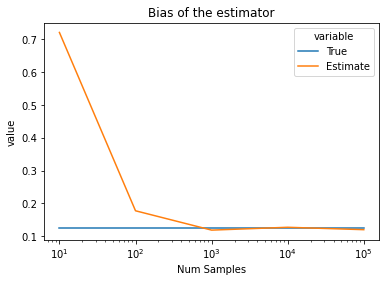

In [8]:
def exp(sample_exp):
    v, w = gen_data(10**sample_exp)
    m = v.mean()
    for i in np.logspace(1, sample_exp - 1, sample_exp - 1, dtype=int):
        est = (w[:i, :].sum(1) / (n * a * ((2 * b) - 1))).mean()
        yield i, m, est

g = sns.lineplot(x='Num Samples', y='value', hue='variable',
                 data=(pd.DataFrame(exp(N), columns=['Num Samples', 'True', 'Estimate'])
                         .melt(id_vars='Num Samples', value_vars=['True' , 'Estimate'])))
g.set(xscale='log', title='Bias of the estimator');

6.922936095294273 4.296761545352393
5.704043263450943 4.296761545352393
4.724118654561403 4.296761545352393
4.408767410180775 4.296761545352393
4.308705553495271 4.296761545352393


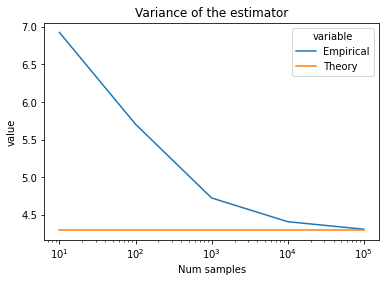

In [9]:
table_csv = []
def exp(sample_exp):
    v, w = gen_data(10**sample_exp)
    ν2 = np.square(v).mean(1).mean()
    b2 = (2 * b) - 1
    est_var = (1 - (a * ν2 * (b2**2)) + ((1 - a) / a)) / (n * (b2**2) * a)
    for i in np.logspace(1, sample_exp - 1, sample_exp - 1, dtype=int):
        emp = (w[:i, :].sum(1) / (n * (a * ((2 * b) - 1)))).var()
        table_csv.append((i, emp, est_var))
        print(emp, est_var)
        yield i, emp, est_var

g = sns.lineplot(x='Num samples', y='value', hue='variable',
                 data=(pd.DataFrame(exp(N), columns=['Num samples', 'Empirical', 'Theory'])
                         .melt(id_vars='Num samples', value_vars=['Empirical' , 'Theory'])))
g.set(xscale='log', title='Variance of the estimator');

In [10]:
v, w = gen_data(10**6)
(w.sum(1) / (n * a * (2 * b - 1))).var()

4.296092394784529

In [11]:
print(pd.DataFrame(table_csv, columns=["Samples", "Empirical", "Theoretical"]).to_csv(index=False, float_format='%.3f'))

Samples,Empirical,Theoretical
10,6.923,4.297
100,5.704,4.297
1000,4.724,4.297
10000,4.409,4.297
100000,4.309,4.297



## Test Chebyshev

In [8]:
from scipy import stats
from scipy import optimize

from tqdm.notebook import tqdm


# Params
K = 10000000 # num clients
n = K // 2
ns = 1  # num samples

In [9]:
# Sammple data

## value distributions
dist0 = stats.norm(loc=-0.2, scale=0.1)
dist1 = stats.norm(loc=0.2, scale=0.1) 

g = np.hstack((np.zeros(shape=(ns, n)), np.ones(shape=(ns, n))))
v = np.hstack((dist0.rvs(size=(ns, n), random_state=0), dist1.rvs(size=(ns, n), random_state=0)))


v0 = np.ma.array(v, mask=g)
ν02 = (v0**2).mean()
true_means0 = v0.mean(1)
print(ν02, true_means0.mean())

0.049987471283302796 -0.19998627914504644


In [59]:
alpha = 0.01
prob = 0.25


def theo_var(x):
    c = expit(x)
    return (1 - (c * ν02 * ((2 * c - 1)**2)) + (((K - n) / n) * ((1 - c) / c))) / (n * ((2 * c - 1)**2) * c)


def chebyshev_upper(x):
    # upper for probability but lower for error
    return theo_var(x) / (alpha**2) - prob


def chebyshev_lower(x):
    # lower for probability but upper bound for error
    M2 = (1 - prob) / prob
    return np.sqrt(M2 * theo_var(x)) - alpha


eps1 = optimize.root(chebyshev_upper, 0.0001)
eps2 = optimize.root(chebyshev_lower, 0.0001)
print(eps1.x[0], eps2.x[0], alpha, prob)

0.3122447216053071 0.2743366541382526 0.01 0.25


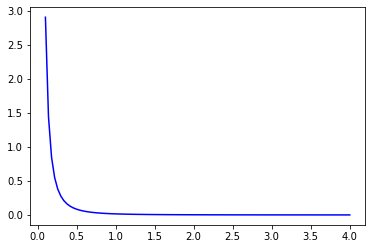

In [60]:
xs = np.linspace(0.1, 4, 100)
var_vect = np.vectorize(theo_var)
ax1 = sns.lineplot(x=xs, y=var_vect(xs) / ((alpha)**2), color='blue')

In [61]:
p = expit(eps1.x[0])

In [62]:
uppers, lowers = [], []
for i in tqdm(range(100)):
    # DP mechanism
    new_g, new_v = g.copy(), v.copy()

    ## protect group
    rr_group = rnd.binomial(1, 1 - p, size=g.shape).astype(bool)
    new_g[rr_group] = 1 - new_g[rr_group]

    ## protect value
    new_v[rr_group] = 0.
    new_v = rnd.binomial(1, (1 + new_v) / 2)
    rr_value = rnd.binomial(1, 1 - p, size=v.shape).astype(bool)
    new_v[rr_value] = 1 - new_v[rr_value]
    new_v = 2 * new_v - 1

    w0 = np.ma.array(new_v, mask=new_g)
    est_mean0 = (w0.sum(1) / (n * p * (2 * p - 1))).mean()
    error = np.abs(est_mean0 - true_means0.mean())
    #est_mean0, true_means0.mean(), error

    uppers.append(int(error > alpha))
    lowers.append(int(error < alpha))
    
# Chebyshev upper (Pr[error  >  alpha] < prob)
emp_prob = sum(uppers) / len(uppers)
print(emp_prob, prob)
assert emp_prob < prob

  0%|          | 0/100 [00:00<?, ?it/s]

0.06 0.25
